In [1]:
!pip install bertopic datasets openai datamapplot

  Obtaining dependency information for bertopic from https://files.pythonhosted.org/packages/98/05/2d6b305391efff89c2b4cf19cf847f971ca163eb5c149d0d2ffac0a9c7ed/bertopic-0.17.3-py3-none-any.whl.metadata
  Obtaining dependency information for datamapplot from https://files.pythonhosted.org/packages/ff/32/5c8e9741c148a385b45174a0fc0af337c8d611e2cfdfec3c8a243febddb2/datamapplot-0.6.3-py3-none-any.whl.metadata
  Obtaining dependency information for hdbscan>=0.8.29 from https://files.pythonhosted.org/packages/64/b1/96c347c7740efa1ac803be64155159284f92fafcff88c1077344e64eead5/hdbscan-0.8.40-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for umap-learn>=0.5.0 from https://files.pythonhosted.org/packages/6b/b1/c24deeda9baf1fd491aaad941ed89e0fed6c583a117fd7b79e0a33a1e6c0/umap_learn-0.5.9.post2-py3-none-any.whl.metadata
  Obtaining dependency information for plotly>=4.7.0 from https://files.pythonhosted.org/packages/95/a9/12e2dc726ba1ba775a2c6922d5d5b4488ad60bdab0888c337c19


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## ArXiv Articles

In [2]:
# Load data from huggingface
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# Extract metadata
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

c:\Users\ptpl-648\Desktop\Hands_on_LLM\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ptpl-648\Desktop\Hands_on_LLM\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ptpl-648\.cache\huggingface\hub\datasets--maartengr--arxiv_nlp. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In o

## A Common Pipeline for Text Clustering

### 1. Embedding Documents

In [4]:
from sentence_transformers import SentenceTransformer

# Create an embedding for each abstract
embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(abstracts[:], show_progress_bar=True)

Batches: 100%|██████████| 1405/1405 [2:14:11<00:00,  5.73s/it]    


In [5]:
embeddings.shape

(44949, 384)

### 2. Reducing the Dimensionality of Embeddings

In [6]:
from umap import UMAP

# We reduce the input embeddings from 384 dimenions to 5 dimenions
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

c:\Users\ptpl-648\Desktop\Hands_on_LLM\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### 3. Cluster the Reduced Embeddings

In [9]:
from hdbscan import HDBSCAN

# We fit the model and extract the clusters
hdbscan_model = HDBSCAN(
    min_cluster_size=50, metric='euclidean', cluster_selection_method='eom'
).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

c:\Users\ptpl-648\Desktop\Hands_on_LLM\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ptpl-648\Desktop\Hands_on_LLM\.venv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:
# How many clusters did we generate?
len(set(clusters))

150

In [13]:
clusters[:15]

array([ -1,  -1,  -1, 132,  93, 102, 102,  -1, 103,  -1,  -1,  65,  93,
        93,  -1], dtype=int64)

### Inspecting the Clusters
Manually inspect the first three documents in cluster 0:

In [14]:
import numpy as np

# Print first three documents in cluster 0
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(abstracts[int(index)][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



Next, we reduce our embeddings to 2-dimensions so that we can plot them and get a rough understanding of the generated clusters.

In [29]:
import pandas as pd

# Reduce 384-dimensional embeddings to 2 dimensions for easier visualization
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# Select outliers and non-outliers (clusters)
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

#### Static plot

(-8.462946581840516, 11.388619589805604, -8.527087140083314, 12.114328789711)

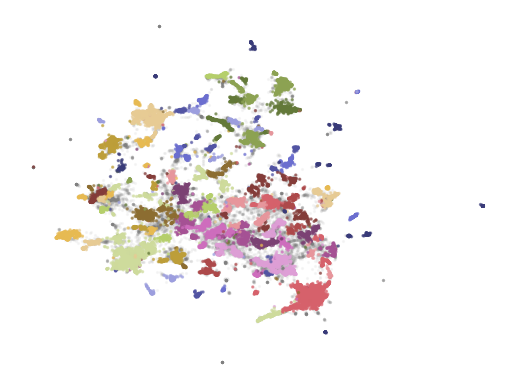

In [30]:
import matplotlib.pyplot as plt

# Plot outliers and non-outliers seperately
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')

### From Text Clustering to Topic Modeling
#### BERTopic: A Modular Topic Modeling Framework

In [31]:
# !pip install --upgrade bertopic sentence-transformers

In [32]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2025-08-24 19:08:45,099 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-24 19:09:24,225 - BERTopic - Dimensionality - Completed ✓
2025-08-24 19:09:24,227 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-24 19:09:27,621 - BERTopic - Cluster - Completed ✓
2025-08-24 19:09:27,631 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-24 19:09:31,791 - BERTopic - Representation - Completed ✓


In [33]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,14222,-1_the_of_and_to,"[the, of, and, to, in, we, language, that, for...",[ Language models have steadily increased in ...
1,0,2202,0_question_questions_answer_qa,"[question, questions, answer, qa, answering, a...",[ While models have reached superhuman perfor...
2,1,2107,1_speech_asr_recognition_end,"[speech, asr, recognition, end, acoustic, spea...",[ Recent advances in text-to-speech (TTS) led...
3,2,1358,2_medical_clinical_biomedical_patient,"[medical, clinical, biomedical, patient, notes...",[ Distributed representations of medical conc...
4,3,910,3_summarization_summaries_summary_abstractive,"[summarization, summaries, summary, abstractiv...",[ Abstractive summarization systems generally...
...,...,...,...,...,...
145,144,54,144_typing_entity_type_types,"[typing, entity, type, types, grained, mention...",[ For the task of fine-grained entity typing ...
146,145,53,145_mixed_code_sentiment_mixing,"[mixed, code, sentiment, mixing, english, anal...",[ In today's interconnected and multilingual ...
147,146,53,146_dialect_identification_arabic_dialects,"[dialect, identification, arabic, dialects, ad...","[ In this paper, we present our approach for ..."
148,147,53,147_memes_meme_hateful_multimodal,"[memes, meme, hateful, multimodal, harmful, me...",[ Memes are becoming a useful source of data ...


Hundreds of topics were generated using the default model! To get the top 10 keywords per topic as well as their c-TF-IDF weights, we can use the get_topic() function:

In [34]:
topic_model.get_topic(0)

[('question', 0.02157975365492854),
 ('questions', 0.016141196007212717),
 ('answer', 0.016090157344112215),
 ('qa', 0.015928331931266956),
 ('answering', 0.015013663807375226),
 ('answers', 0.01005000806774396),
 ('retrieval', 0.009640000292331108),
 ('comprehension', 0.007832068752808941),
 ('reading', 0.0072878195764788595),
 ('the', 0.006412560392150337)]

We can use the find_topics() function to search for specific topics based on a search term. Let’s search for a topic about topic modeling:

topic_model.find_topics("topic modeling")

It returns that topic 22 has a relatively high similarity (0.95) with our search term. If we then inspect the topic, we can see that it is indeed a topic about topic modeling:

In [35]:
topic_model.get_topic(22)

[('adversarial', 0.06464607974362714),
 ('attacks', 0.03251239754106016),
 ('attack', 0.03155489219271329),
 ('robustness', 0.022592574705474055),
 ('examples', 0.018761233300207594),
 ('perturbations', 0.014413484289992748),
 ('defense', 0.010907914190008267),
 ('perturbation', 0.010332738418594325),
 ('nlp', 0.009336133135905799),
 ('against', 0.008940458312241068)]

That seems like a topic that is, in part, characterized by the classic LDA technique. Let's see if the BERTopic paper was also assigned to topic 22:

In [36]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

23

It is! We expected it might be because there are non-LDA specific words in the topic describtion such as "clustering" and "topic".

### Visualizations
#### Visualize Documents

In [38]:
print(type(titles))

<class 'list'>


In [39]:
print(type(titles[0]))

<class 'str'>


In [40]:
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(abstracts)  # only pass documents!

2025-08-24 19:16:09,724 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1405/1405 [16:37:29<00:00, 42.60s/it]       
2025-08-25 11:53:41,981 - BERTopic - Embedding - Completed ✓
2025-08-25 11:53:41,983 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-25 12:02:34,482 - BERTopic - Dimensionality - Completed ✓
2025-08-25 12:02:34,488 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-25 12:03:03,099 - BERTopic - Cluster - Completed ✓
2025-08-25 12:03:03,126 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-25 12:03:15,319 - BERTopic - Representation - Completed ✓


In [42]:
# # Reduce embeddings to 2D
# from umap import UMAP
# reduced_embeddings = UMAP(n_components=2, min_dist=0.0, metric="cosine", random_state=42)\
#     .fit_transform(embeddings).tolist()

# # Ensure titles are strings
# titles = list(map(str, titles))

# # Visualize
# fig = topic_model.visualize_documents(
#     titles,
#     reduced_embeddings=reduced_embeddings,
#     width=1200,
#     hide_annotations=True
# )
# fig.update_layout(font=dict(size=16))
# fig.show()


In [43]:
# # Ensure titles is a Python list of strings
# titles = list(map(str, titles))

# # Ensure reduced_embeddings is a list of lists (instead of numpy)
# reduced_embeddings = reduced_embeddings.tolist()

# fig = topic_model.visualize_documents(
#     titles,
#     reduced_embeddings=reduced_embeddings,
#     width=1200,
#     hide_annotations=True
# )

# fig.update_layout(font=dict(size=16))


In [47]:
# !pip install -U nbformat

In [48]:
# Visualize barchart with ranked keywords
topic_model.visualize_barchart()

# Visualize relationships between topics
topic_model.visualize_heatmap(n_clusters=30)

# Visualize the potential hierarchical structure of topics
topic_model.visualize_hierarchy()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': {'bdata': 'AAAAAAAAAAAkxVcelAjZPyTFVx6UCNk/AAAAAAAAAAA=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAAAAFMAAAAAAAAAUwAAAAAAAAC7AAAAAAAAALsA=', 'dtype': 'f8'},
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(61,153,112)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': {'bdata': 'JMVXHpQI2T+O4f8IouHmP47h/wii4eY/AAAAAAAAAAA=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAAAAJMAAAAAAAAAkwAAAAAAAADnAAAAAAAAAOcA=', 'dtype': 'f8'},
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': {'bdata': 'AAAAAAAAAADWjLUDBzrjP9aMtQMHOuM/AAAAAAAAAAA=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAACAQcAAAAAAAIBBwAAAAAAAgEbAAAAAAACARsA=', 'dtype': 'f8'},
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': {'bdata': 'AAAAAAAAAAAMz0Jh3I3hPwzPQmHcjeE/AAAAAAAAAAA=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAACAS8AAAAAAAIBLwAAAAAAAQFDAAAAAAABAUMA=', 'dtype': 'f8'},
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': {'bdata': 'AAAAAAAAAABvj1PUQw3jP2+PU9RDDeM/AAAAAAAAAAA=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAADAUsAAAAAAAMBSwAAAAAAAQFXAAAAAAABAVcA=', 'dtype': 'f8'},
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': {'bdata': 'DM9CYdyN4T81Jpg1k+blPzUmmDWT5uU/b49T1EMN4z8=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAAAATsAAAAAAAABOwAAAAAAAAFTAAAAAAAAAVMA=', 'dtype': 'f8'},
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': {'bdata': 'AAAAAAAAAAA4chqLzJbkPzhyGovMluQ/AAAAAAAAAAA=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAADAV8AAAAAAAMBXwAAAAAAAQFrAAAAAAABAWsA=', 'dtype': 'f8'},
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': {'bdata': 'NSaYNZPm5T/lvkozLSXoP+W+SjMtJeg/OHIai8yW5D8=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAACAUcAAAAAAAIBRwAAAAAAAAFnAAAAAAAAAWcA=', 'dtype': 'f8'},
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(255,65,54)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': {'bdata': '1oy1Awc64z82rAiDIPfpPzasCIMg9+k/5b5KMy0l6D8=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAAAARMAAAAAAAABEwAAAAAAAQFXAAAAAAABAVcA=', 'dtype': 'f8'},
              'yaxis': 'y'},
             {'hoverinfo': 'text',
              'marker': {'color': 'rgb(35,205,205)'},
              'mode': 'lines',
              'type': 'scatter',
              'x': {'bdata': 'AAAAAAAAAABOXt0xkjTSP05e3TGSNNI/AAAAAAAAAAA=', 'dtype': 'f8'},
              'xaxis': 'x',
              'y': {'bdata': 'AAAAAABAX8AAAAAAAEBfwAAAAAAA4GDAAAAAAADgYMA=', 'dtype': 'f8'},
              'yaxis': 'y'},
             {'hoverinfo': 'text',
   

### Representation Models

In these examples that follow, we will update our topic representations after having trained our model. This allows for quick iteration. If, however, you want to use a representation model at the start of training, you will need to run it as follows:

from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

##### Create your representation model
representation_model = KeyBERTInspired()

##### Use the representation model in BERTopic on top of the default pipeline
topic_model = BERTopic(representation_model=representation_model)
To use the representation models, we are first going to duplicate our topic model such that easily show the differences between a model with and without representation model.

In [49]:
# Save original representations
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [50]:
def topic_differences(model, original_topics, nr_topics=5):
    """Show the differences in topic representations between two models """
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # Extract top 5 words per topic per model
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

#### KeyBERTInspired

In [51]:
from bertopic.representation import KeyBERTInspired

# Update our topic representations using KeyBERTInspired
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,question | questions | answer | qa | answering,answering | questions | comprehension | retrie...
1,1,speech | asr | recognition | end | acoustic,phonetic | transcription | speech | language |...
2,2,medical | clinical | biomedical | patient | notes,nlp | clinical | ehr | ehrs | concepts
3,3,summarization | summaries | summary | abstract...,summarization | summarizers | summaries | summ...
4,4,hate | offensive | speech | detection | toxic,hate | hateful | language | offensive | languages


#### Maximal Marginal Relevance

In [52]:
from bertopic.representation import MaximalMarginalRelevance

# Update our topic representations to MaximalMarginalRelevance
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

,Topic,Original,Updated
0,0,question | questions | answer | qa | answering,questions | retrieval | comprehension | knowle...
1,1,speech | asr | recognition | end | acoustic,speech | asr | error | model | automatic
2,2,medical | clinical | biomedical | patient | notes,clinical | biomedical | patient | extraction |...
3,3,summarization | summaries | summary | abstract...,summarization | document | extractive | rouge ...
4,4,hate | offensive | speech | detection | toxic,offensive | toxicity | abusive | comments | ha...


#### Text Generation
##### Flan-T5

In [53]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Update our topic representations using Flan-T5
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

100%|██████████| 150/150 [00:38<00:00,  3.89it/s]


,Topic,Original,Updated
0,0,question | questions | answer | qa | answering,Question answering | | | |
1,1,speech | asr | recognition | end | acoustic,Speech-to-speech | | | |
2,2,medical | clinical | biomedical | patient | notes,Science/Tech | | | |
3,3,summarization | summaries | summary | abstract...,Abstractive summarization | | | |
4,4,hate | offensive | speech | detection | toxic,Science/Tech | | | |


#### OpenAI

import openai
from bertopic.representation import OpenAI

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
"""

# Update our topic representations using GPT-3.5
client = openai.OpenAI(api_key="YOUR_KEY_HERE")
representation_model = OpenAI(
    client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# Show topic differences
topic_differences(topic_model, original_topics)

In [57]:
# Visualize topics and documents
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    # label_font_size=11,
    # label_wrap_width=20,
    # use_medoids=True,
)
plt.savefig("datamapplot.png", dpi=300)

TypeError: only integer scalar arrays can be converted to a scalar index